#Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

#Data

In [4]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
            'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
            'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','class','difficulty_level']

In [5]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTrain+.txt", names = features)
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/KDDTest+.txt", names = features)

print(train_df.shape)
print(test_df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(125967, 43)
(22549, 43)


In [6]:
#combining train and test files (there's an error when doing the one hot encoding)
data = pd.concat([train_df, test_df])
print(data.shape)
data.head()

(148516, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [7]:
data.info()
""" 
  'protocol_type','srevice', 'flag' : categorical types
  'difficulty_level'                : usless
  'class'                           : has multiplie classes of attaks and a normal class
  
  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148516 entries, 0 to 22548
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148516 non-null  int64  
 1   protocol_type                148516 non-null  object 
 2   service                      148516 non-null  object 
 3   flag                         148516 non-null  object 
 4   src_bytes                    148516 non-null  int64  
 5   dst_bytes                    148516 non-null  int64  
 6   land                         148516 non-null  int64  
 7   wrong_fragment               148516 non-null  int64  
 8   urgent                       148516 non-null  int64  
 9   hot                          148516 non-null  int64  
 10  num_failed_logins            148516 non-null  int64  
 11  logged_in                    148516 non-null  int64  
 12  num_compromised              148516 non-null  int64  
 13  

" \n  'protocol_type','srevice', 'flag' : categorical types\n  'difficulty_level'                : usless\n  'class'                           : has multiplie classes of attaks and a normal class\n  \n  'is_host_login','land', 'logged_in','is_guest_login' : binary no need for normalizing\n"

In [8]:
#some stats
data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000
mean,276.781168,40228.220165,17088.968657,0.000215,0.020523,0.000202,0.189380,0.004323,0.402792,0.255063,0.001508,0.000976,0.273728,0.012073,0.000525,0.004013,0.000000,0.000081,0.012308,83.333695,28.252121,0.256926,0.255339,0.137942,0.138481,0.672987,0.067755,0.097442,183.927563,119.463458,0.534524,0.084097,0.145933,0.030584,0.256123,0.251306,0.136215,0.136391,19.278495
std,2460.691310,5409629.816013,3703537.248657,0.014677,0.240070,0.019417,2.013167,0.072248,0.490461,22.231450,0.038807,0.042389,22.689100,0.517865,0.027701,0.095257,0.000000,0.008989,0.110259,116.755909,75.369855,0.431919,0.432579,0.339382,0.341777,0.436542,0.194651,0.258886,98.528487,111.232267,0.448061,0.194088,0.308638,0.108975,0.428501,0.429720,0.322736,0.335276,2.739760
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,278.000000,571.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0.000000,21.000000
max,57715.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,101.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,100.000000,5.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [9]:
#fixing labels
data.loc[data['class']!='normal','class']= 'attack'

##Data visualisation

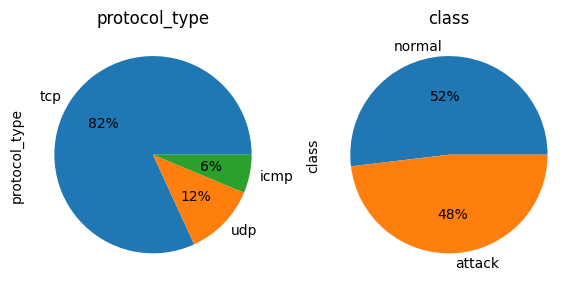

In [10]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(7, 7), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()
pie_plot(data, ['protocol_type', 'class'], 1, 2)

# prétraitement



#### 1-Normalisation (Robuste)

In [11]:
#les colonnes doivent etre numeriques seulement
def normalisation(dataframe, columns):
  normalised_df = pd.DataFrame(RobustScaler().fit_transform(dataframe), columns = columns)
  return normalised_df
  

In [12]:
categorical_columns = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'difficulty_level', 'class']

In [13]:

def preprocessing(dataframe):
  #selectionner le valeurs numeriques puis les normaliser
  num_df = dataframe.drop(categorical_columns, axis=1)
  num_cols = num_df.columns
  normalized_df = normalisation(num_df, num_cols)


  #supression des ancienne données numeriques et rajout des données normalisées
  dataframe.drop(labels = num_cols, axis= 'columns', inplace = True)
  dataframe[num_cols] = normalized_df[num_cols]

  #remplaces les lables de la colonne 'class": 
  #0 => normal
  #1 => attak
  dataframe.loc[dataframe['class'] == "normal", "class"]= 0
  dataframe.loc[dataframe['class'] != 0, "class"] = 1 

  #onehot encoding
  dataframe = pd.get_dummies(dataframe, columns = ['protocol_type','service', 'flag'])

  return dataframe

In [14]:
normalized_df = preprocessing(data)
normalized_df

,land,logged_in,is_host_login,is_guest_login,class,difficulty_level,duration,src_bytes,dst_bytes,wrong_fragment,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,20,0.0,1.607914,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,15,0.0,0.366906,0.000000,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,19,0.0,-0.158273,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,21,0.0,0.676259,14.278459,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,21,0.0,0.557554,0.735552,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22544,0,0,0,0,0,20,0.0,1.003597,1.052539,0.0,...,0,0,0,0,0,0,0,0,1,0
22545,0,0,0,0,0,21,0.0,1.057554,0.686515,0.0,...,0,0,0,0,0,0,0,0,1,0
22546,0,0,0,0,1,17,0.0,-0.158273,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
22547,0,0,0,0,1,17,0.0,0.870504,1.602452,0.0,...,1,0,0,0,0,0,0,0,0,0


##### Feature selection (reduction) PCA

In [15]:
#Extraction des X et Y
x = normalized_df.drop(['class', 'difficulty_level'], axis = 1).values
y = normalized_df['class'].values.astype('int')
y_reg = normalized_df['difficulty_level'].values

#initialisation PCA
pca = PCA(n_components = 21)
pca = pca.fit(x)
x_r = pca.transform(x)

print("# Of original features: ", x.shape[1])
print("# Features after reduction: ", x_r.shape[1])

#Training splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

xr_train, xr_test, yr_train, yr_test = train_test_split(x_r, y, test_size = 0.3, random_state = 42)

xreg_train, xreg_test, yreg_train, yreg_test = train_test_split(x, y_reg, test_size = 0.3 , random_state = 42)


# Of original features:  121
# Features after reduction:  21


In [16]:
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)

x_train shape :  (103961, 121)
y_train shape :  (103961,)


#Models and evaluation


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

evaluations = {}

def evaluate(model, model_name, x_train, x_test, y_train, y_test):
    # Convertir les prédictions du modèle en classes prédites
    train_pred = np.argmax(model.predict(x_train), axis=1)
    test_pred = np.argmax(model.predict(x_test), axis=1)

    # Calculer les métriques d'évaluation
    train_acc = metrics.accuracy_score(y_train, train_pred)
    test_acc = metrics.accuracy_score(y_test, test_pred)

    train_rec = metrics.recall_score(y_train, train_pred)
    test_rec = metrics.recall_score(y_test, test_pred)

    train_pre = metrics.precision_score(y_train, train_pred)
    test_pre = metrics.precision_score(y_test, test_pred)

    train_f1 = metrics.f1_score(y_train, train_pred)
    test_f1 = metrics.f1_score(y_test, test_pred)

    # Enregistrer les résultats dans le dictionnaire d'évaluations
    evaluations[model_name] = [train_acc, test_acc, train_pre, test_pre, train_rec, test_rec, train_f1, test_f1]

    # Afficher les résultats
    print(f"{model_name} Results:")
    print(f"Training Accuracy: {train_acc*100:.2f}%  Test Accuracy: {test_acc*100:.2f}%")
    print(f"Training Precision: {train_pre*100:.2f}%  Test Precision: {test_pre*100:.2f}%")
    print(f"Training Recall: {train_rec*100:.2f}%  Test Recall: {test_rec*100:.2f}%")
    print(f"Training F1 Score: {train_f1*100:.2f}%  Test F1 Score: {test_f1*100:.2f}%")

    # Matrice de confusion
    cm = metrics.confusion_matrix(y_test, test_pred)
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Attack'])
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.grid(False)
    cm_display.plot(ax=ax)
    plt.show()


#### Models


In [20]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(121, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test,y_test),batch_size = 32)

Epoch 1/20
3249/3249 [==============================] - 19s 5ms/step - loss: 0.4933 - accuracy: 0.9431 - val_loss: 0.1154 - val_accuracy: 0.9587
Epoch 2/20
3249/3249 [==============================] - 15s 5ms/step - loss: 0.1166 - accuracy: 0.9611 - val_loss: 0.0885 - val_accuracy: 0.9675
Epoch 3/20
3249/3249 [==============================] - 16s 5ms/step - loss: 0.1547 - accuracy: 0.9640 - val_loss: 0.0813 - val_accuracy: 0.9688
Epoch 4/20
3249/3249 [==============================] - 17s 5ms/step - loss: 0.3484 - accuracy: 0.9671 - val_loss: 0.1075 - val_accuracy: 0.9773
Epoch 5/20
3249/3249 [==============================] - 19s 6ms/step - loss: 0.3041 - accuracy: 0.9689 - val_loss: 0.0656 - val_accuracy: 0.9791
Epoch 6/20
3249/3249 [==============================] - 16s 5ms/step - loss: 0.0891 - accuracy: 0.9725 - val_loss: 0.0609 - val_accuracy: 0.9792
Epoch 7/20
3249/3249 [==============================] - 18s 5ms/step - loss: 0.3048 - accuracy: 0.9712 - val_loss: 0.0655 - val_ac

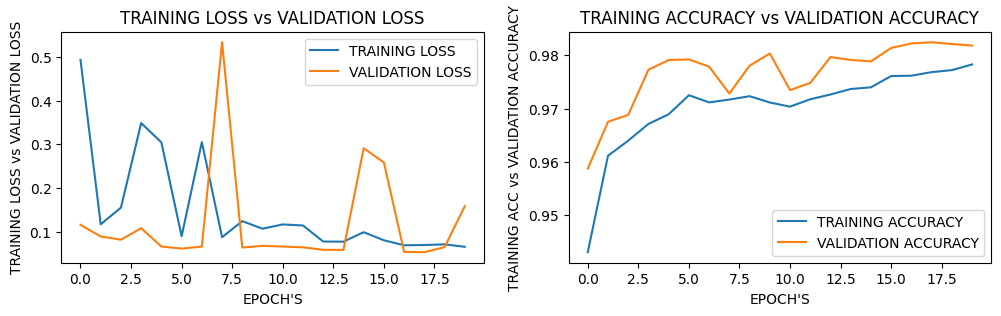

In [27]:
#use matplitlib to draw the plots of last epoch
plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = "TRAINING LOSS")
plt.plot(history.history['val_loss'], label = "VALIDATION LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING LOSS vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = "TRAINING ACCURACY")
plt.plot(history.history['val_accuracy'], label = "VALIDATION ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

1393/1393 [==============================] - 2s 2ms/step
cnn Results:
Training Accuracy: 98.22%  Test Accuracy: 98.18%
Training Precision: 99.00%  Test Precision: 99.03%
Training Recall: 97.27%  Test Recall: 97.20%
Training F1 Score: 98.13%  Test F1 Score: 98.11%


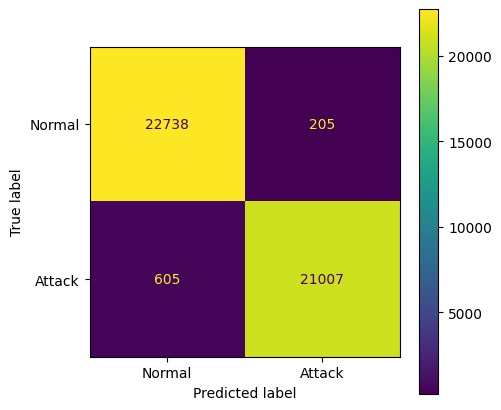

In [25]:
evaluate(model, "cnn", x_train, x_test, y_train, y_test)